# Prospecção de Dados (Data Mining) DI/FCUL - HA1

## First Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`01`

* Catherine Prokhorov (62608) - 3 Hours worked on the project
* Guilherme Cepeda (62931) - 1 Hours worked on the project
* Jorge Aleluia, (54549) - Hours worked on the project
* Rómulo Nogueira (56935) - Hours worked on the project




The purpose of this Home Assignment is
* Read a Data file with a Set of Texts
* Compute similarities between texts
* Perform simple classification of texts using a Naive Bayes classifier

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**


## 1. Read the Dataset

The dataset is the file `Sentences_75Agree.txt` from the [Financial Sentiment Analysis database on Gugging Face](https://huggingface.co/datasets/financial_phrasebank)

* Read the dataset and separate them by unique documents (one document per line)
* The last word of each document is the class and it **must be removed from the document** but kept separate for use in the classification tasks below
    * classes can be `.@positive`, `.@negative`, `.@neutral`
    


In [68]:
### Your code Here
import re

# Forma 1 de fazer
file = open('Sentences_75Agree.txt', 'r').readlines()
docs = {}
classes = {}
pattern = r'(@(?:positive|negative|neutral))\b'

i = 0
for line in file:
    l = re.split(pattern, line)
    docs[i] = l[0]
    classes[i] = l[1]
    i += 1


print(docs)
print(classes)
    
# Forma 2 de fazer
# file = open('Sentences_75Agree.txt', 'r').readlines()
# docs = {}
# classes = {}

# i = 0
# for line in file:
#     docs[i] = " ".join(line.split()[:-1])
#     classes[i] = line.split()[-1]
#     i += 1

# print(docs)
# print(classes)



{0: 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 1: 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .', 2: "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .", 3: 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .', 4: 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .', 5: 'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .', 6: "TeliaSonera TLSN said the offer is in line with its strategy to increase its 

## 2. Compute similarities between texts

* Compute the TF.IDF of all words in texts
* compute the average similarity beween texts
* Plot the document similarity distribution (suggestion use [boxplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) or [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) or  [histograms with density](https://matplotlib.org/stable/gallery/statistics/histogram_features.html))
* Comment your results


In [70]:
# Funções auxiliares
from math import log2
import unicodedata
import numpy as np

def basic_word_tokenizer(text):
    return text.split()

def remove_accents(s):
    nfkd_form = unicodedata.normalize('NFKD', s)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stuff(s):
    for c in "\\\t0123456789Ææœ—‘’\ufeff{|}“”.,()$£%&[]?@#!=;*+–\"ǁ":
        s=s.replace(c, "")
    s=s.replace("-", " ")
    return s

def get_words_from_corpus(corpus):
    words_texts=[]
    for _,text in corpus.items():
        text=text.strip().lower()
        text=remove_accents(text)
        text=remove_stuff(text)
        text=text.lower()
        words = basic_word_tokenizer(text)
        words_texts.append(words)
    return words_texts


def calc_all_words(words_text_sets):
    all_words=set()
    for words in words_text_sets: all_words |= words
    return all_words

def calc_all_words_v2(words_texts):
    all_words = set()
    for set_words in words_texts.values():
        all_words |= set_words
    
    return all_words


def word_counter(words):
    """How many times each word appears in the set of words
    """

    #1. get uniques
    unique_words=set(words)
    #2. make a dictionary for counting
    D=dict(zip(unique_words, [0]*len(unique_words)))
    #3. count all
    for w in words: D[w]+=1
    return D

def TF(word_counts):
    #get the counts
    counts  = word_counts.values()
    if len(counts)==0: return {}
    the_max = max(counts)   #compute the maximum
    #return a dictionary that for each word returns the ratio of wc/max_wc
    return dict(zip(word_counts.keys(), [c/the_max for c in counts]))


def IDF(all_words, doc_word_counts):
    #first initialize a new dictionary with one entry for each word
    D=dict(zip(all_words, [0]*len(all_words)))
    N=len(doc_word_counts)
    for doc in doc_word_counts:
        for word in doc: D[word]+=1
    return {w: log2(N/D[w]) for w in D}


def cosine_similarity_tfidf(idx1, idx2, words_text_sets, all_tfs, idfs):
    text1= words_text_sets[idx1]
    text2= words_text_sets[idx2]
    tfs1=all_tfs[idx1]
    tfs2=all_tfs[idx2]

    common_words = text1 & text2
    if len(common_words)==0: return 0.0
    common_tfidfs = [tfs1[w]*tfs2[w]*idfs[w]*idfs[w] for w in common_words]

    #squared tfidfs
    tfidfs2_1=np.array([tfs1[w]*idfs[w] for w in text1])**2
    tfidfs2_2=np.array([tfs2[w]*idfs[w] for w in text2])**2

    return sum(common_tfidfs)/(np.sqrt(tfidfs2_1.sum())*np.sqrt(tfidfs2_2.sum()))

def text_similarities(words_text_sets, all_tfs, idfs):
    N=len(words_text_sets)
    sims={}
    for i in range(N-1):
        for j in range(i+1, N):
            sim = cosine_similarity_tfidf(i,j, words_text_sets, all_tfs, idfs)
            # sims.append((sim, (i,j)))
            sims[(i,j)] = sim
    return sims



In [71]:
words_texts = get_words_from_corpus(docs)

words_text_sets = {i:set(words_texts[i]) for i in range (len(words_texts))}
# words_text_sets

# words_text_sets_2 = [set(words) for words in words_texts]
# all_words=calc_all_words(words_text_sets_2)

all_words_v2 = calc_all_words_v2(words_text_sets)


# Check para ver se é o mesmo - É
# all_words == all_words_v2


all_tfs = {}
for i in range(len(words_texts)):
    words = words_texts[i]
    occor = word_counter(words_texts[i])
    all_tfs[i] = TF(occor)

all_idfs = IDF(all_words_v2, words_text_sets.values())

sims = text_similarities(words_text_sets, all_tfs, all_idfs)

dict_ordenado = sorted(sims.items(), key=lambda x: x[1], reverse=True)
dict_ordenado

[((129, 130), 1.0000000000000002),
 ((132, 133), 1.0000000000000002),
 ((132, 134), 1.0000000000000002),
 ((132, 135), 1.0000000000000002),
 ((133, 134), 1.0000000000000002),
 ((133, 135), 1.0000000000000002),
 ((134, 135), 1.0000000000000002),
 ((520, 526), 1.0000000000000002),
 ((1434, 1435), 1.0000000000000002),
 ((1544, 1545), 1.0000000000000002),
 ((1982, 1983), 1.0000000000000002),
 ((2188, 2189), 1.0000000000000002),
 ((2195, 2196), 1.0000000000000002),
 ((2838, 2869), 1.0000000000000002),
 ((3377, 3378), 1.0000000000000002),
 ((89, 204), 1.0),
 ((89, 206), 1.0),
 ((89, 207), 1.0),
 ((89, 209), 1.0),
 ((89, 212), 1.0),
 ((127, 128), 1.0),
 ((202, 210), 1.0),
 ((202, 211), 1.0),
 ((204, 206), 1.0),
 ((204, 207), 1.0),
 ((204, 209), 1.0),
 ((204, 212), 1.0),
 ((206, 207), 1.0),
 ((206, 209), 1.0),
 ((206, 212), 1.0),
 ((207, 209), 1.0),
 ((207, 212), 1.0),
 ((209, 212), 1.0),
 ((210, 211), 1.0),
 ((941, 942), 1.0),
 ((958, 959), 1.0),
 ((1343, 2479), 1.0),
 ((1495, 1787), 1.0),
 (

In [72]:
avg = round(sum(sims.values()) / len(sims),5)
print("Similaridade média: ", avg)

Similaridade média:  0.01787


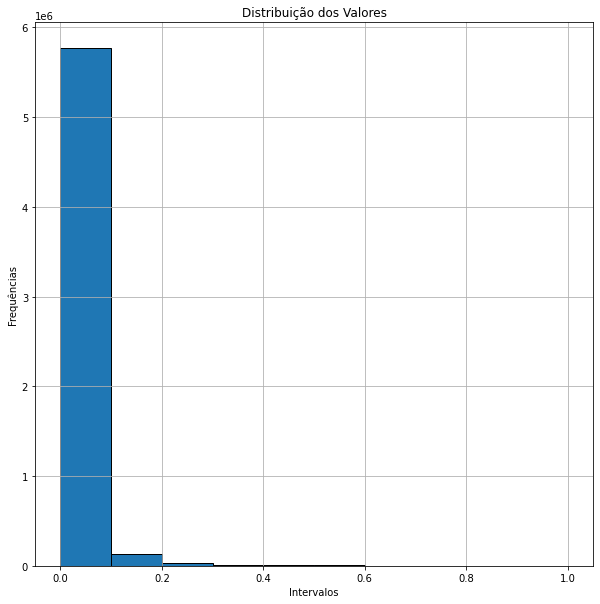

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

valores = list(sims.values())

# Plotar o histograma dos valores
plt.hist(valores, bins=10, edgecolor='black')

plt.xlabel('Intervalos')
plt.ylabel('Frequências')
plt.title('Distribuição dos Valores')
plt.grid(True)
plt.show()


### Your short analysis here

Através da análise do histograma é percetivel que a grande maioria dos textos têm baixa similaridade entre sí justificando assim a baixa média de 0.01787.


## 3. Make a Naive Bayes Classifier 

* Split dataset randomly into training and testing (20% for testing)
* Train a Naive Bayes Model and do some sensitivity analyis on the hyperparameters 
* Evaluate your results with the testing set


In [114]:
### Add supporting functions here
from random import sample, shuffle

def calc_prior_counts(labels):
    yv, yc=np.unique(labels, return_counts=True)
    priors=np.ones(len(yv))
    priors[yv]=yc
    return priors

def calc_all_words(words_text_sets):
    #joins all the words from lists of words in documents to get a unique set of all the words
    all_words=set()
    for words in words_text_sets: all_words |= words
    return all_words


def init_likelihood_counts(docs_words, n_labels):
    all_words=calc_all_words(docs_words)
    L_hoods={}
    for w in all_words:
        L_hoods[w]=np.zeros(n_labels)
    return L_hoods


def update_likelihood_counts(L_hoods, words, label):
    for word in words: 
        L_hoods[word][label]+=1

def calc_likelihood_counts(docs_words, labels):
    n_labels=len(set(labels)) #!!! <- not very bright!
    L_hoods = init_likelihood_counts(docs_words, n_labels)
    for i, words in enumerate(docs_words): 
        update_likelihood_counts(L_hoods, words, labels[i])
    return L_hoods

def make_train_test(X, y, r=0.25 ):
    N=len(X)
    D=list(range(N))
    shuffle(D)
    train_set_X = [X[i] for i in D[int(N*r):]]
    train_set_y = [y[i] for i in D[int(N*r):]]
    test_set_X = [X[i] for i in D[:int(N*r)]]
    test_set_y = [y[i] for i in D[:int(N*r)]]
    return train_set_X, train_set_y, test_set_X, test_set_y

def classify_new_document(words, priors, L_hoods, alpha=0):
    res=priors/priors.sum()
    alpha_vec=np.ones(len(res))*alpha
    for word in words:
        if word in L_hoods: 
            res*=(L_hoods[word]/L_hoods[word].sum() + alpha_vec)
    return res/res.sum()

def classify_documents(docs, priors, L_hoods, alpha=0):
    return [classify_new_document(words, priors, L_hoods, alpha).argmax(axis=0) for words in docs]

In [133]:
### Add processing code here
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, precision_score, recall_score

# mapeamento = {
#     "@positive" : 0,
#     "@neutral" : 1,
#     "@negative": 2
# }

# reversed_mapeamento = {valor: chave for chave, valor in mapeamento.items()}

# labs = list(map(lambda v: mapeamento[v], classes.values()))
# word_sbs = list(words_text_sets.values())


# word_sbs_train, labs_train, word_sbs_test, labs_test = make_train_test(word_sbs, labs, r=0.2)

# PC = calc_prior_counts(labs_train)
# LHC=calc_likelihood_counts(word_sbs_train, labs_train)

# preds=classify_documents(word_sbs_test, PC, LHC, alpha=0.0001)

# for i, words in enumerate(word_sbs_test[:20]):
#     print(i, "--", reversed_mapeamento[preds[i]], "<--", words)


# print("The F1 score is: %7.4f" % f1_score(labs_test, preds))
# print("The MCC score is: %7.4f" % matthews_corrcoef(labs_test, preds))
# print("The precision score is: %7.4f" %  precision_score(labs_test, preds))
# print("The recall score is: %7.4f" %  recall_score(labs_test, preds))

# print(confusion_matrix(labs_test, preds))

ImportError: cannot import name 'InconsistentVersionWarning' from 'sklearn.exceptions' (C:\Users\letic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\exceptions.py)

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used in a Big Data environment


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
